# **Dependancies**

In [1]:
import keras_tuner as kt

from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.optimizers import *
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from datetime import datetime
# from tqdm import tqdm

from sklearn.preprocessing import MinMaxScaler, RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, PredefinedSplit
from sklearn.ensemble import GradientBoostingRegressor

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from collections import Counter
from scipy.stats import uniform
from scipy.stats import randint


2022-12-03 12:34:00.147239: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# **Loading Data**

In [3]:
selected = pd.read_csv("../Data/train_btc_selected_features.csv")
btc = pd.read_csv("../Data/btc_Data.csv")
btc['Date'] = pd.to_datetime(btc['Date'])
btc = btc.set_index("Date")

In [4]:
btcData = btc[selected.columns]
btcData['returns'] = btcData['priceUSD'].pct_change().copy()
Data = btcData.drop(columns=['priceUSD'])
Data = Data[1:]
# divide X and Y
X = Data.iloc[:,0:]
#Y = Data['returns']   # 用returns的话就用这一行，然后把下一行comment掉
Y = btcData['priceUSD'].shift(-30)[1:] # 反之亦然
# Split into three data sets
X_train = X['2016-01-01':'2019-12-31']
X_val = X['2020-01-01':'2021-05-31']
X_test = X['2021-06-01':'2023-01-01']

Y_train = Y['2016-01-01':'2019-12-31']
Y_val = Y['2020-01-01':'2021-05-31']
Y_test = Y['2021-06-01':'2023-01-01']

/tmp/ipykernel_199068/3854812091.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  btcData['returns'] = btcData['priceUSD'].pct_change().copy()


In [5]:
estimators=[]
estimators.append(['mixmax',MinMaxScaler()])
estimators.append(['robust',RobustScaler()])
scale=Pipeline(estimators,verbose=True)
scale.fit(X_train)
X_train=scale.transform(X_train)
X_test=scale.transform(X_test)
X_val = scale.transform(X_val)

[Pipeline] ............ (step 1 of 2) Processing mixmax, total=   0.0s
[Pipeline] ............ (step 2 of 2) Processing robust, total=   0.0s


In [6]:
X_train=np.reshape(X_train,(X_train.shape[0],1,X_train.shape[1]))
X_val=np.reshape(X_val,(X_val.shape[0],1,X_val.shape[1]))
X_test=np.reshape(X_test,(X_test.shape[0],1,X_test.shape[1]))
Y_train=Y_train.values
Y_train=np.reshape(Y_train, (Y_train.shape[0],1,1))
Y_val=Y_val.values
Y_val=np.reshape(Y_val, (Y_val.shape[0],1,1))
Y_test=Y_test.values
Y_test=np.reshape(Y_test, (Y_test.shape[0],1,1))

In [7]:
def lr_schedule(epoch):
    """Learning Rate Schedule

    Learning rate is scheduled to be reduced after 80, 120, 160, 180 epochs.
    Called automatically every epoch as part of callbacks during training.

    # Arguments
        epoch (int): The number of epochs

    # Returns
        lr (float32): learning rate
    """
    lr = 1e-3
    if epoch > 180:
        lr *= 0.5e-3
    elif epoch > 160:
        lr *= 1e-3
    elif epoch > 120:
        lr *= 1e-2
    elif epoch > 80:
        lr *= 1e-1
    print('Learning rate: ', lr)
    return lr

In [8]:
adam=Adam(lr=lr_schedule(0),amsgrad=True)


Learning rate:  0.001


/home/spectre/anaconda3/envs/tensorplustorch/lib/python3.10/site-packages/keras/optimizers/optimizer_v2/adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [9]:
def build_model(hp):
    model = Sequential()

    #first layer
    model.add(Bidirectional(LSTM(hp.Int('input_unit1',min_value=32,max_value=512,step=32), return_sequences=True, activation='relu'), input_shape=(1, X_train.shape[2])))
    for i in range(hp.Int('n_layers', 1, 3)):
        model.add(Bidirectional(LSTM(hp.Int(f'input_unit{i+1}',min_value=32,max_value=512,step=32), return_sequences=True, activation='relu')))
    #dropout layer
    model.add(Dropout(hp.Float('Dropout_rate',min_value=0,max_value=0.5,step=0.1)))
    # Dense layer
    model.add(Dense(1, activation=hp.Choice('dense_activation',values=['relu', 'sigmoid'],default='relu')))
    model.compile(loss="logcosh", optimizer='adam', metrics=['mae'])
    return model

In [10]:
tuner= kt.RandomSearch(
        build_model,
        objective='val_mse',
        max_trials=10,
        executions_per_trial=1,
        directory='ltc_tune',
        project_name='LSTM_TUNE'
        )

tuner.search(
        x=X_train,
        y=Y_train,
        epochs=5000,
        batch_size=32,
        validation_data=(X_val,Y_test),
)

2022-12-03 12:34:02.642459: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-03 12:34:02.644429: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.



Search: Running Trial #1

Value             |Best Value So Far |Hyperparameter
192               |?                 |input_unit1
1                 |?                 |n_layers
0.2               |?                 |Dropout_rate
sigmoid           |?                 |dense_activation

Epoch 1/5000
46/46 [==============================] - 4s 34ms/step - loss: 5026.1304 - mae: 5026.8242 - val_loss: nan - val_mae: nan
Epoch 2/5000
46/46 [==============================] - 1s 33ms/step - loss: 5025.9751 - mae: 5026.6680 - val_loss: nan - val_mae: nan
Epoch 3/5000
46/46 [==============================] - 2s 33ms/step - loss: 5025.9746 - mae: 5026.6680 - val_loss: nan - val_mae: nan
Epoch 4/5000
46/46 [==============================] - 1s 29ms/step - loss: 5025.9756 - mae: 5026.6670 - val_loss: nan - val_mae: nan
Epoch 5/5000
46/46 [==============================] - 1s 25ms/step - loss: 5025.9736 - mae: 5026.6689 - val_loss: nan - val_mae: nan
Epoch 6/5000
46/46 [==============================]

KeyboardInterrupt: 

In [ ]:
# Get the best hyperparameters.
best_hp = tuner.get_best_hyperparameters()[0]
# Build the model with the best hp.
regressor = build_model(best_hp)
# Fit with the entire dataset.
X_val = np.concatenate((X_train, X_val))
Y_val = np.concatenate((Y_train, Y_val))


In [ ]:
earlyStopping = EarlyStopping(monitor='loss', patience=1000, verbose=1, mode='auto')

In [ ]:
regressor.fit(x=X_all, y=Y_all, epochs=5000, batch_size=32, use_multiprocessing=True, callbacks=[earlyStopping])

In [ ]:

y_pred=regressor.predict(X_test)

In [ ]:
# for check
Y_train_pred=regressor.predict(X_train)
r2_score(Y_train, Y_train_pred) #training score

1461/1461 [==============================] - 0s 127us/step


0.9966428561796283

In [ ]:
r2=r2_score(Y_test[:-30],y_pred[:-30]) #score/ r^2
print(f'r2:{r2}')

r2:0.3289147112445364


In [ ]:
# r2_oos
def r2_oos(ret, pred):
    sum_of_sq_res = np.nansum(np.power((ret-pred), 2))
    sum_of_sq_total = np.nansum(np.power(ret, 2))
    
    return 1-sum_of_sq_res/sum_of_sq_total

In [ ]:
r2_oos = r2_oos(Y_test[:-30], y_pred[:-30])
print(f'r2_oos:{r2_oos}')

r2_oos:0.9181680230673898


In [ ]:
mae=mean_absolute_error(Y_test[:-30],y_pred[:-30]) #mae
print(f'mae:{mae}')

rmse=np.sqrt(mean_squared_error(Y_test[:-30],y_pred[:-30])) #rmse
print(f'rmse:{rmse}')

mape=mean_absolute_percentage_error(Y_test[:-30],y_pred[:-30]) #mape
print(f'mape:{mape}')

mae:8630.756097837935
rmse:11084.832551513839
mape:24.996031025506138


-----------------------------

In [ ]:
pre_df = pd.DataFrame(zip(Y_test,y_pred),columns=['Y_test','y_pred'])
pre_df.index = Y_test.index
pre_df

546/546 [==============================] - 0s 83us/step


,y_test,y_pred
Date,,
2021-06-01,33731.0,34394.320312
2021-06-02,33285.0,34062.855469
2021-06-03,34298.0,33482.195312
2021-06-04,35271.0,34105.074219
2021-06-05,34100.0,33992.710938
...,...,...
2022-11-24,NaN,24159.792969
2022-11-25,NaN,23844.636719
2022-11-26,NaN,23678.773438


In [ ]:
pre_df['pred_returns'] = pre_df['y_pred'].pct_change()

In [ ]:
pre_df

,y_test,y_pred,pred_returns
Date,,,
2021-06-01,33731.0,34394.320312,NaN
2021-06-02,33285.0,34062.855469,-0.009637
2021-06-03,34298.0,33482.195312,-0.017047
2021-06-04,35271.0,34105.074219,0.018603
2021-06-05,34100.0,33992.710938,-0.003295
...,...,...,...
2022-11-24,NaN,24159.792969,-0.012123
2022-11-25,NaN,23844.636719,-0.013045
2022-11-26,NaN,23678.773438,-0.006956


<AxesSubplot:>

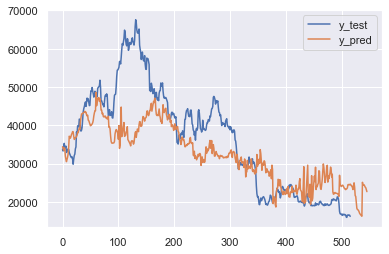

In [ ]:
pd.DataFrame(zip(Y_test,y_pred),columns=['Y_test','y_pred']).plot()

In [ ]:
pre_df.to_csv("../result/LSTM/btc_lstm.csv")

In [ ]:

!kdeconnect-cli -n TAS-AN00 --ping-msg 'Script complete!'